In [35]:
%load_ext autoreload
%autoreload 2

import meep as mp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
print(mpl.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
3.4.0


## Fields in a waveguide

1) ერთი ვორტიქსის სიგრძე, ანუ ჩვენს შემთხვევაში კვადრატის სიგრძე, ანუ h არის დაახლოვებით 10 ნანომეტრი.

2) Q პარამეტრი დაივიწყეთ. რაც გვიწერია სტატიაში omega/c*Q ეს იგივეა რაც h/lambda. lambda კი თავის მხრივ სიხშირეზეა დამოკიდებული.
თუ მაგალითად აიღებთ ჩვენს შემთხვევაში როგორც ჩვენის შედეგების ნახაზზეა, მაგალითად, განუზომელ პარამეტრს 0.53, ეს ნიშნავს, რომ h/lambda=0.53
ანუ თუ ვიცით, რომ  h=10 ნმ, ესეიგი ლამბდა არის 10/0.53=18.8679 ნმ. შესაბამისად შეგიძლიათ აქედან გაიგოთ სიხშირე, თუმცა არ მგონია რომ
სიხშირის გაგება გჭირდებოდეთ, მგონია რომ პერიოდი და ტალღის სიგრძე საკმარისია. 

ჯერ ნახეთ  h/lambda=0.53 და  h/lambda=0.58, სადაც ნამდვილად გასვლა გვაქვს. ამას იმიტომ ვამბობ, რომ არეკვლის სიმძლავრე დამოკიდებულია
ფენების რაოდენომაზე (როგორც ფოტონიკებში გვქონდა, 5-ს რომ ვიღებდით), შესაბამისად მე უნდა დავთვალო თქვენ რამდენ ფენასაც აიღებთ იქ
რამდენად ძლიერი იქნება არეკვლა. არეკვლა რომ იქნება ცხადია, თუმცა რამდენად ძლიერი, შეიძლება ნაწილი გავიდეს. 
რაც შეეხება h/lambda=0.53 და  h/lambda=0.58 აქ სრული გასვლაა და პრობლემა არ არის. 

მარტივია, მაგრამ მაინც იხილეთ ბმული ფაილი. ამ მარტივი გარდაქმნით პირდაპირ გამოდის 9.21 ფორმულა.
ანუ დროით ორმაგი წარმოებულები ჩაწერილი ამ ფორმით. აქედან პირდაპი 9.21.
თუ ახლა, უბრალოდ შესამოწმებლად, დაუშვებთ რომ ომეგა_დ=0 (გამმა_დ ყოველთვის ნულია ჩვენთან რადგანაც მილევა არ გვაქვს),
მიიღებთ დროის ყველა ეტაპზე ცნობილ დამოკიდებულებას D და E ვექტორებს შორის, კერძოდ D=eps_0*eps*E.
მოკლედ მე თითქმის დარწმუნებული ვარ, რომ თუ თქვენ სწორედ 
გამოიყენებთ ამ 9.21 ფორმულას, უნდა გადაიჭრას ჩვენი პრობლემა. ასევე ყურადღება მიაქციეთ სულ ბოლო წინადადებას
გაყვითლებული რომ მაქვს, სადაც რეალურად წერია რა მონაცემებით უნდა გააკეთოთ "აპდეითი" ახალი მონაცემების.
მოკლედ ერთი დამეტებითი D ვექტორის შემოტანა მოგიწევთ.


In [36]:
# scale is nanometers
eps = .5
width = 1


ratio = 0.53
h = 10 # nanometers
lamd = h / ratio # nanometers
k_0 = 1 - 0.01 * (h/lamd) ** -2 # Used for eps hat calculation

pml_size = lamd * 0.50
pml_sep = lamd * 0.08
pml_depth = pml_size + pml_sep # nm
simulation_area = np.array([6 * 10, 13 * 10, 0])
grid_size = simulation_area + [pml_depth * 2, pml_depth * 2, 0] # nm

courant_factor = 0.5
courant = courant_factor * (eps ** .5) / (2 ** .5) # no dim. 


# this is pixels per scale (nanometers here). 
# The vortices have size 10nmx10nm, and consist of 
# 6x6 cells. So, the resolution should be
resolution = 10 / 6

In [55]:
1 - 0.001 *(h / lamd) ** (-2) # Might be wrong!

0.996440014239943

In [37]:
cell = mp.Vector3(*grid_size)
cell # nanometers

Vector3<81.88679245283018, 151.88679245283018, 0.0>

In [40]:
pml_layers = [mp.PML(pml_size)]

In [56]:
vortex = [
    ['v'] + ['<'] * 5,
    ['v'] * 2 + ['<'] * 3 + ['^'],
    ['v'] * 3 + ['<'] + ['^'] * 2,
    ['v'] * 2 + ['>'] + ['^'] + ['^'] * 2,
    ['v'] * 1 + ['>'] * 3 + ['^'] * 2,
    ['>'] * 5 + ['^'],
]

from math import pi
vortex = np.array(vortex)


def eps_function(rot):
    eps_1 = 1 - k_0 * np.sin(rot) ** 2 # first eps (for Ex)
    eps_3 = 1 - k_0 * np.cos(rot) ** 2 # middle eps (for Ey)
    eps_4 = 1 # last eps (For Ez)
    return mp.Vector3((eps_1, eps_3, eps_4))

for a,b in zip(list('v>^<'),[1.5 * pi, 0, .5 * pi, pi]):
    vortex = np.where(vortex == a, b, vortex)

vortex_material = mp.Medium(epsilon_diag=(eps, eps, 1),)

In [100]:
resolution * pml_depth

18.238993710691823

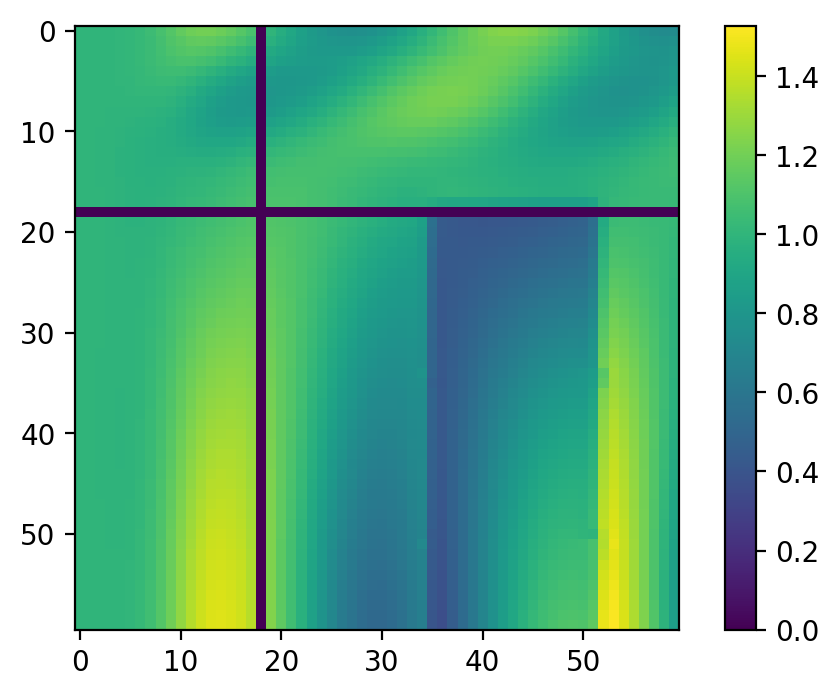

In [103]:
x = sim.get_efield().copy().sum(-1)
x += sim.get_epsilon().copy()
x[int(resolution * pml_depth), :] = 0
x[:,int(resolution * pml_depth),] = 0
plt.figure(dpi=200)
plt.imshow(x[:60,:60])
plt.colorbar()

151.88679245283018 81.88679245283018
     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon dia

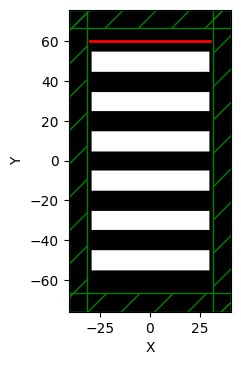

In [43]:
# for 
geometry = []
W,H, _ = grid_size
D = pml_depth
print(H,W)

sources = [
    mp.Source(
        mp.ContinuousSource(
            wavelength=lamd,
            ),
        component=mp.Hz, #  NOTE: Direction matters!
        size=mp.Vector3(W - D * 2 , 0, 0),
        center=mp.Vector3(0, H/2 - D - h * .5, 0)
    )
]

for y in np.linspace(
    start = H/2-D-h*1.5,
    stop = -(H/2-D-h*1.5),
    num = 6, endpoint=True):
    for x in np.linspace(
        start = W/2-D-h*0.5,
        stop = -(W/2-D-h*0.5),
        num = 6, 
        endpoint=True):
        geometry.append(
            mp.Block(
                mp.Vector3(10,10,mp.inf),
                center=mp.Vector3(x,y,0),
                material=vortex_material
            )
        )

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
    Courant=courant,
)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [44]:
sim.run(until=350)

/home/tornikeo/.anaconda3/envs/vortex/lib/python3.7/site-packages/meep/simulation.py:2041: RuntimeWarning: Epsilon < 1 may require adjusting the Courant parameter. See the 'Numerical Stability' entry under the 'Materials' section of the documentation
  warnings.warn(eps_warning, RuntimeWarning)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000257969 s
Working in 2D dimensions.
Computational cell is 81.6 x 151.8 x 0 with resolution 1.66667
     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     bl

FloatProgress(value=0.0, description='0% done ', max=350.0)

run 0 finished at t = 350.09999999999997 (2334 timesteps)


     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, cen

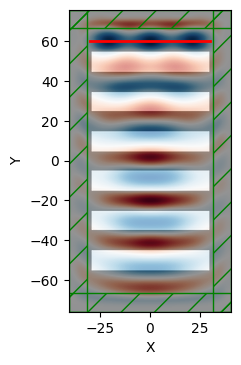

In [45]:
plt.figure(dpi=100)
sim.plot2D(fields=mp.Hz)
plt.show()

## Animation

In [46]:
sim.reset_meep()
f = plt.figure()
anim = mp.Animate2D(sim, fields=mp.Hz, f=f, realtime=False, normalize=True)
plt.close()

In [47]:
sim.run(mp.at_every(1,anim), until=250)
plt.close()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000255823 s
Working in 2D dimensions.
Computational cell is 81.6 x 151.8 x 0 with resolution 1.66667
     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     bl

FloatProgress(value=0.0, description='0% done ', max=250.0)

     block, center = (25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-5,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-15,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, center = (-25,50,0)
          size (10,10,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (0.5,0.5,0.5)
     block, cen

In [48]:
filename = "media/low_eps.mp4"
anim.to_mp4(10,filename)

Generating MP4...


In [49]:
from IPython.display import Video
Video(filename)